In [13]:
#Импортируем необходимые библиотеки

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import shapiro 
import statsmodels.formula.api as smf 

In [6]:
#Загрузим исходные данные

users_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-pozdniakov/statistic/ab_users_data.csv')
orders = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-pozdniakov/statistic/ab_orders.csv')
products = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-pozdniakov/statistic/ab_products.csv')

Исходя из того, что данные нормализованы по трем таблицам нам необходимо преобразовать данные для удобства вычислений и анализа
ввиду того, что поле product_ids в dataFrame orders неудобно для анализа - преобразуем его в список 

In [7]:
orders.product_ids = orders.product_ids.apply(lambda x: x.replace('{','').replace('}','').split(', '))
orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"[75, 22, 53, 84]"
1,1256,2022-08-26 00:02:21.000000,"[56, 76, 39]"
2,1257,2022-08-26 00:02:27.000000,"[76, 34, 41, 38]"
3,1258,2022-08-26 00:02:56.000000,"[74, 6]"
4,1259,2022-08-26 00:03:37.000000,"[20, 45, 67, 26]"


Объединим данные из таблицы users_data и orders и оставим в полученной таблице только те данные, которые в дальнейшем нам будут полезны для анализа

In [133]:
users_data_with_orders = users_data.join(orders.set_index('order_id'), how='inner', on='order_id')

#Убедимся что временной диапазон проведения теста одинаков в обеих группах

users_data_with_orders.date = pd.to_datetime(users_data_with_orders.date)
print(users_data_with_orders.query('group == 0').sort_values('date').date.head(1).values, 
      users_data_with_orders.query('group == 0').sort_values('date').date.tail(1).values)
print(users_data_with_orders.query('group == 1').sort_values('date').date.head(1).values, 
      users_data_with_orders.query('group == 1').sort_values('date').date.tail(1).values)

#Отберем необходимые поля
users_data_with_orders = users_data_with_orders[['user_id','order_id','action','group','product_ids']]

['2022-08-26T00:00:00.000000000'] ['2022-09-08T00:00:00.000000000']
['2022-08-26T00:00:00.000000000'] ['2022-09-08T00:00:00.000000000']


Примем что одной из необходимых для анализа метрик может стать количество купленных товаров, для этого создадим
дополнительный столбец с количеством товаров в заказе

In [ ]:
users_data_with_orders['count_products'] = users_data_with_orders.product_ids.apply(lambda x: len(x))

In [8]:
#Учитывая что у нас есть заказы, которые были отменены, исключим их из имеющейся выборки

cancel_orders = users_data_with_orders.query('action == "cancel_order"').order_id.to_list()
users_data_with_orders_without_cancel = users_data_with_orders[users_data_with_orders.order_id.isin(cancel_orders) == False]

#Добавим еще одну метрику - стоимость заказа, для этого извлечем стоимости товаров и их id из таблицы products,
# затем объединим их в словарь dict_product{id:price}

product_ids = products.product_id.to_list()
product_prices = products.price.to_list()
dict_product = dict(zip(product_ids,product_prices))

#Напишем простую функцию для извлечения списка стоимостей товаров по списку id товаров в заказе

def return_price_list(list_products_id, dict_product_id_price):
    price_list = []
    for i in list_products_id:
        price_list.append(dict_product_id_price[int(i)])
    return price_list

#Импользуя нашу функцию и извлеченные ранее данные создадим новое поле в нашем df содержащее список стоимостей товаров в заказе

users_data_with_orders_without_cancel['product_prices'] = users_data_with_orders_without_cancel \
                                                                .product_ids \
                                                                .apply(lambda x: return_price_list(x,dict_product))

#создадим еще одно поле содержащее стоимость заказа и отберем необходимые нам данные

users_data_with_orders_without_cancel['order_price'] = users_data_with_orders_without_cancel['product_prices'] \
                                                            .apply(lambda x: sum(x))

users_data_with_orders_without_cancel = users_data_with_orders_without_cancel[['user_id', 'order_id', 'action', 'group', 'count_products', 'order_price']]

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


the number of orders in the zero group 1527
the number of orders in the test group 2382
the number of users in the zero group 512
the number of users in the test group 501
zero group info(total_price):
count     512.000000
mean     1139.562305
std       809.808924
min        25.000000
25%       571.700000
50%       955.700000
75%      1498.600000
max      5589.800000
Name: total_price, dtype: float64 

first group info(total_price):
count     501.000000
mean     1753.749301
std       928.760937
min        83.500000
25%      1065.800000
50%      1630.100000
75%      2376.000000
max      4576.200000
Name: total_price, dtype: float64


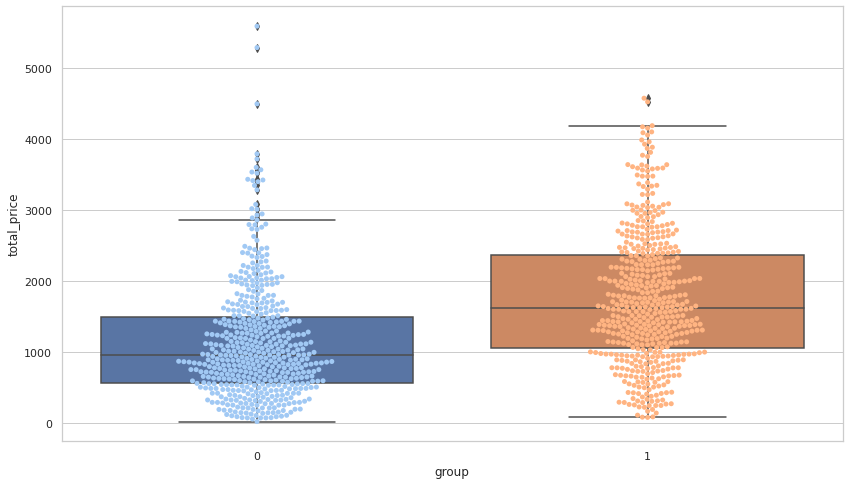

In [9]:
#Выведем количество пользователей и заказов по группам

zero_group = users_data_with_orders_without_cancel.query('group == 0')
first_group = users_data_with_orders_without_cancel.query('group == 1')

print('the number of orders in the zero group',zero_group.order_id.count())
print('the number of orders in the test group',first_group.order_id.count())
print('the number of users in the zero group',zero_group.user_id.nunique())
print('the number of users in the test group',first_group.user_id.nunique())

#Тестовая(1) группа содержит большее число заказов(2382 против 1527 в 0-группе)
#Количество пользователей в обеих группах близко(515 и 502) 
#посмотрим на распределение наших метрик используя граффики вида boxplot + swarmplot. сначала на стоимость заказов по группам
#Для этого сгруппируем наши данные по пользователям и группам и получим в качестве результата группировки 
#суммарную стоимость всех заказов - total_price, а также суммарное количество заказанных товаров total_products

data_modify = users_data_with_orders_without_cancel \
                        .groupby(['user_id','group'], as_index=False) \
                        .agg({'order_price':'sum','count_products':'sum'}) \
                        .rename(columns={'order_price':'total_price','count_products':'total_products'})

sns.set(style='whitegrid', rc={'figure.figsize' : (14,8)})
sns.boxplot(y='total_price', x='group', data = data_modify)
sns.swarmplot(y='total_price', x='group', data = data_modify, palette='pastel')

#На граффиках наблюдается явная внутригрупповая ассиметрия, медиана смещена относительно центра коробки, усы неравноудалены, 
#а также видно явное асимметричное распределение между группами 
#Как вывод следует, что по текущей метрике(total_price) наблюдения в группах распределены анормально 
#и имеют выраженные визуальные различия, 1-гпруппа расположена выше и ,вцелом, имеет больший размах, 
#медиана отличимо больше чем у 0-группы
#Посмотрим на меры изменчивости total_price по группам:

print('zero group info(total_price):')
print(data_modify.query('group==0').total_price.describe(),'\n')
print('first group info(total_price):')
print(data_modify.query('group==1').total_price.describe())

#Практически все харрактеристики первой группы(тестовой) по метрике total_price выше чем у нулевой(mean, median(50%), std)

zero group info(total_products):
count    512.000000
mean       9.966797
std        6.454786
min        1.000000
25%        5.000000
50%        9.000000
75%       13.000000
max       43.000000
Name: total_products, dtype: float64 

first group info(total_products):
count    501.000000
mean      15.928144
std        7.618322
min        1.000000
25%       11.000000
50%       15.000000
75%       20.000000
max       44.000000
Name: total_products, dtype: float64


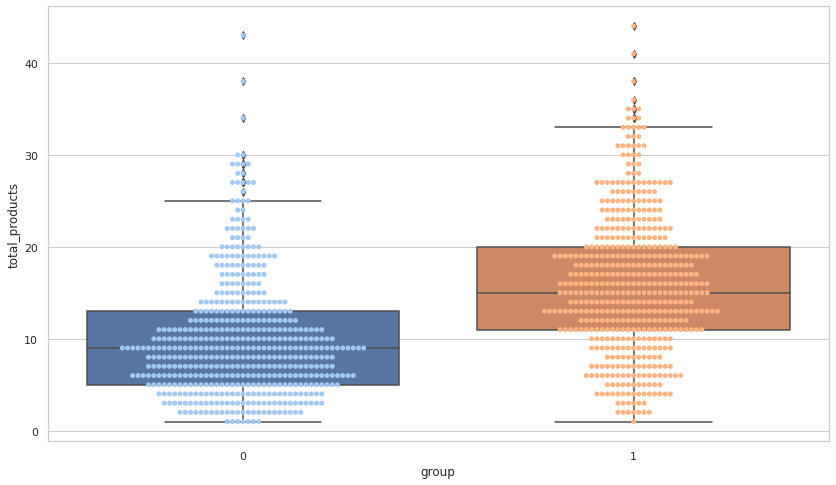

In [10]:
#Теперь проверим распределение метрики "суммарное количество заказанных товаров"

sns.boxplot(y='total_products', x='group', data = data_modify)
sns.swarmplot(y='total_products', x='group', data = data_modify, palette='pastel')

#На граффиках в первой группе наблюдается ассиметрия, но менее выраженная чем в метрике total_price,
#о нормальности тестовай группы(1) сказать сложно, медиана несколько смещена относительно центра, Усы boxplot неравноудалены, 
#имеются односторонние выбросы
#Очевидно асимметричное распределение между группами, меры центральной тенденции и изменчивости в тестовой группе(1)
# выше чем в 0-группе
#Как вывод следует, что по текущей метрике(суммарная стоимость заказов)сложно сказать о нормальности распределения 
#1-группа расположена выше и вцелом имеет больший размах, медиана отличимо больше чем у 0-группы
#Посмотрим на меры изменчивости total_products по группам:

print('zero group info(total_products):')
print(data_modify.query('group==0').total_products.describe(),'\n')
print('first group info(total_products):')
print(data_modify.query('group==1').total_products.describe())

#Как вывод, по метрике total_products, все основные харрактеристики первой группы(тестовой) по метрике total_price 
#выше чем у нулевой(mean, median(50%), std) 

In [11]:
#Проведем тест Шапиро-Уилка на нормальность распределения по каждой из наших метрик и групп

#Нулевая группа
print('тест Шапиро-Уилка для количества товаров в заказе 0-группы:')
print(shapiro(data_modify.query('group==0').total_products))
print('тест Шапиро-Уилка для стоимости заказа 0-группы:')
print(shapiro(data_modify.query('group==0').total_price))

#Тестовая группа
print('тест Шапиро-Уилка для количества товаров в заказе тест-группы:')
print(shapiro(data_modify.query('group==1').total_products))
print('тест Шапиро-Уилка для стоимости заказа тест-группы:')
print(shapiro(data_modify.query('group==1').total_price),'\n')

#Вывод из теста Шапиро-Уилка - распределение наблюдений обеих наших метрик внутри групп не является нормальным

тест Шапиро-Уилка для количества товаров в заказе 0-группы:
ShapiroResult(statistic=0.896943986415863, pvalue=4.579423658735965e-18)
тест Шапиро-Уилка для стоимости заказа 0-группы:
ShapiroResult(statistic=0.88853520154953, pvalue=8.713836969217895e-19)
тест Шапиро-Уилка для количества товаров в заказе тест-группы:
ShapiroResult(statistic=0.979967474937439, pvalue=2.2058020476833917e-06)
тест Шапиро-Уилка для стоимости заказа тест-группы:
ShapiroResult(statistic=0.9748774170875549, pvalue=1.408598961916141e-07) 



In [ ]:
#Ввиду ненормальности распределений наблюдений по нашим метрикам и наличии больших выбросов, t-test использовать не будем

In [12]:
#проверим наши группы на гомогенность дисперсий используя тест Левина по среднему значению
#Тест необходим для принятия решения о проведении дисперсионного анализа

print(stats.levene(data_modify.query('group==0').total_price, data_modify.query('group==1').total_price, center='mean'))
print(stats.levene(data_modify.query('group==0').total_products, data_modify.query('group==1').total_products, center='mean'))

#pvalue для обеих метрик меньше 0.05 соответственно Дисперсии наших данных статистически значимо отличаются
#Как следствие - дисперсионный анализ нам не подходит

LeveneResult(statistic=17.790652899975363, pvalue=2.6871370781197887e-05)
LeveneResult(statistic=17.58173513153073, pvalue=2.9934094567086917e-05)


Ввиду ненормальности распределения и отсутствия гомогенности дисперсий
Проведем анализ средних используя метод bootstrap из библиотеки scipy.stats

сначала посмотрим на доверительные интервалы каждой группы для выборочных средних метрики "суммарная стоимость заказов"

In [93]:
bt_zero_total_price_mean = stats.bootstrap((data_modify.query('group==0').total_price.to_list(),), np.mean)
bt_first_total_price_mean = stats.bootstrap((data_modify.query('group==1').total_price.to_list(),), np.mean)
print(bt_zero_total_price_mean,'\n')
print(bt_first_total_price_mean)

BootstrapResult(confidence_interval=ConfidenceInterval(low=1072.1454315740152, high=1213.5155033464648), standard_error=35.655799004643114) 

BootstrapResult(confidence_interval=ConfidenceInterval(low=1677.0335737252933, high=1838.62622821045), standard_error=41.61304654539625)


доверительные интервалы не пересекаются, что может говорить о статистически значимой разнице между группами по этой метрике
посмотрим на доверительные интервалы каждой группы для выборочных средних метрики "суммарное количество заказанных товаров"

In [ ]:
bt_zero_total_products_mean = stats.bootstrap((data_modify.query('group==0').total_products.to_list(),), np.mean)
bt_first_total_products_mean = stats.bootstrap((data_modify.query('group==1').total_products.to_list(),), np.mean)
print(bt_zero_total_products_mean,'\n')
print(bt_first_total_products_mean)

доверительные интервалы также не пересекаются

Проведем дополнительные тесты с использованием bootstrap чтобы найти доверительные интервалы эффекта различия между группами

Сначала для метрики суммарная стоимость заказов

bootstrap возвращает доверительный интервал средних значений, возьмем среднее из полученного доверительного интервала для каждой из групп и найдем их разницу.
Проведем эту процедуру 500 раз (придется немного подождать, по хорошему эту процедуру лучше было провернуть 10000 раз но ждать неимоверно долго, а вывод о нормальности можно сделать и на основании 500 элементов), и поместим полученные разницы в список.

Построим граффик и посмотрим на распределение разниц

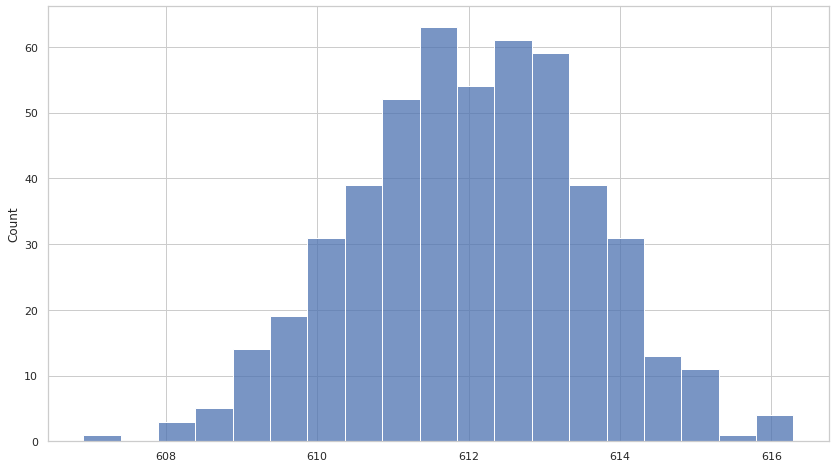

In [81]:
diff_mean_total_price = []

for i in range(500):
    bt_zero_total_price_mean = stats.bootstrap((data_modify.query('group==0').total_price.to_list(),), np.mean)
    bt_first_total_price_mean = stats.bootstrap((data_modify.query('group==1').total_price.to_list(),), np.mean)

    zero_mean = np.mean([bt_zero_total_price_mean.confidence_interval[1], bt_zero_total_price_mean.confidence_interval[0]])
    first_mean = np.mean([bt_first_total_price_mean.confidence_interval[1], bt_first_total_price_mean.confidence_interval[0]])

    diff_mean_total_price.append(first_mean - zero_mean)

sns.histplot(diff_mean_total_price)

Мы видем что распределение нашей разницы между средними в группах имеет нормальный вид
Найдем доверительный интервал полученной разницы нашего результата

In [83]:
stats.t.interval(0.95, len(diff_mean_total_price) - 1, loc=np.mean(diff_mean_total_price))

(610.0596370394486, 613.989095821424)

Вывод: доверительный интервал разницы между выборочными средними в наших группах статистически значимо отличается, положительный и не имеет перехода через ноль

проведем ту же процедуру для метрики суммарное количество приобретенных товаров

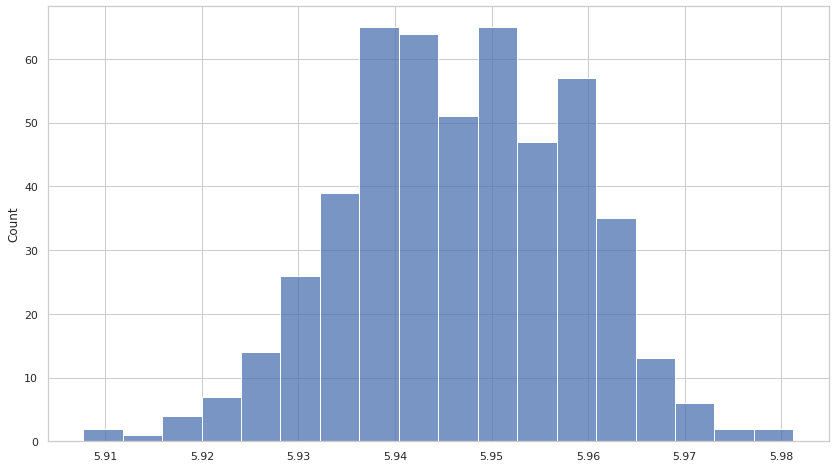

In [84]:
diff_mean_total_products = []

for i in range(500):
    bt_zero_total_products_mean = stats.bootstrap((data_modify.query('group==0').total_products.to_list(),), np.mean)
    bt_first_total_products_mean = stats.bootstrap((data_modify.query('group==1').total_products.to_list(),), np.mean)

    zero_mean = np.mean([bt_zero_total_products_mean.confidence_interval[1], bt_zero_total_products_mean.confidence_interval[0]])
    first_mean = np.mean([bt_first_total_products_mean.confidence_interval[1], bt_first_total_products_mean.confidence_interval[0]])

    diff_mean_total_products.append(first_mean - zero_mean)

sns.histplot(diff_mean_total_products)

In [ ]:
Аналогично предидущей метрике распределение нашей разницы между средними в группах также имеет нормальный вид
Найдем доверительный интервал полученной разницы нашего результата второй метрики

In [89]:
stats.t.interval(0.95, len(diff_mean_total_products) - 1, loc=np.mean(diff_mean_total_products))

(3.9819464306326973, 7.9114052126080265)

Вывод: доверительный интервал разницы между выборочными средними в наших группах по суммарному количеству товаров статистически значимо отличается, положительный и не имеет перехода через ноль

Общий Вывод: Ввиду того что в тестовой группе суммарное количество товаров, которое заказывают пользователи увеличилось в среднем на 6 единиц, а суммарная стоимость заказов увеличилась на 611(валюта), и разница между группами является положительно статистически значимой, рекомендуется выкатить новую систему рекомендаций на всех пользователей